In [1]:
import os
import sys

current_dir = os.getcwd()

# Walk up the directory tree until we find 'src'
path = current_dir
src_path = None

while True:
    if os.path.basename(path) == "src":
        src_path = path
        break
    parent = os.path.dirname(path)
    if parent == path:  # reached filesystem root
        break
    path = parent

# Add src to sys.path if found
if src_path and src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import AutoRec model and data utilities
from utils.model import AutoRec
from utils.autorecdata import AutoRecData
from utils.preprocessor import PreProcessor
from helpers.data_downloader import download_ml1m_dataset
# Import external libraries
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
print("=" * 70)
print("Imports Successful")
print("=" * 70)

Imports Successful


/Users/abbas/Documents/Codes/thesis/recommender/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'data')
data_path = os.path.join(data_dir,'ml-1m', 'ratings.dat')
print(data_path)
print(data_dir)
# Check if file exists
if not os.path.exists(data_path):
    download_ml1m_dataset(data_dir=data_dir)

def load_ml_1m_data(data_path = data_path) -> pd.DataFrame:  
    print("=" * 70)
    print("Loading MovieLens 1M Dataset")
    print("=" * 70)
    print(f"Data path: {data_path}")
    return pd.read_csv(
        data_path,
        sep='::',
        header=None,
        names=['user_id', 'item_id', 'rating', 'timestamp'],
        engine='python',  # Explicitly use python engine to avoid warning
        dtype={
            'user_id': np.int32,
            'item_id': np.int32,
            'rating': np.float32,
            'timestamp': np.int32
        }
    )


# Load ratings data with proper engine to avoid warnings
print("\nLoading ratings data...")

ratings_df = load_ml_1m_data()

print(f"✓ Successfully loaded {len(ratings_df):,} ratings")
print("=" * 70)

/Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
/Users/abbas/Documents/Codes/thesis/recommender/src/../data

Loading ratings data...
Loading MovieLens 1M Dataset
Data path: /Users/abbas/Documents/Codes/thesis/recommender/src/../data/ml-1m/ratings.dat
✓ Successfully loaded 1,000,209 ratings


In [3]:
# Create PreProcessor instance
preprocessor = PreProcessor()

# Preprocess the data: split into train/test and create rating matrices
# Paper uses 90-10 split (test_size=0.1)
print("\nSplitting data into train/test sets and creating rating matrices...")
print("=" * 70)
train_mat, test_mat, num_users, num_items = preprocessor.preprocess_ml1m_data(
    ratings_df, 
    test_size=0.1,  # 10% for testing (90-10 split as per paper)
    random_state=42  # For reproducibility
)

print(f"✓ Data preprocessing complete!")
print(f"Train matrix shape: {train_mat.shape}, Test matrix shape: {test_mat.shape}")
print("=" * 70)


Splitting data into train/test sets and creating rating matrices...
✓ Data preprocessing complete!
Train matrix shape: (6040, 3706), Test matrix shape: (6040, 3706)


In [4]:
# Split training data into train and validation sets
# Paper mentions holding out 10% of training set for hyperparameter tuning
# We'll use 10% of training data for validation
from sklearn.model_selection import train_test_split

# Convert train_mat to list of (user, item, rating) tuples for splitting
train_ratings = []
for user in range(train_mat.shape[0]):
    for item in range(train_mat.shape[1]):
        if train_mat[user, item] > 0:
            train_ratings.append((user, item, train_mat[user, item]))

# Split into train and validation (90-10 split of training data)
train_ratings_split, val_ratings_split = train_test_split(
    train_ratings, test_size=0.1, random_state=42
)

# Create new train and validation matrices
train_mat_new = np.zeros_like(train_mat)
val_mat = np.zeros_like(train_mat)

for user, item, rating in train_ratings_split:
    train_mat_new[user, item] = rating

for user, item, rating in val_ratings_split:
    val_mat[user, item] = rating

# Create datasets for item-based AutoRec
# item_based=True means we iterate over item vectors (columns of rating matrix)
train_set = AutoRecData(data=train_mat_new, item_based=True)
val_set = AutoRecData(data=val_mat, item_based=True)
test_set = AutoRecData(data=test_mat, item_based=True)

print(f"Training set: {train_mat_new.shape}, {np.count_nonzero(train_mat_new):,} ratings")
print(f"Validation set: {val_mat.shape}, {np.count_nonzero(val_mat):,} ratings")
print(f"Test set: {test_mat.shape}, {np.count_nonzero(test_mat):,} ratings")
print("=" * 70)

Training set: (6040, 3706), 810,169 ratings
Validation set: (6040, 3706), 90,019 ratings
Test set: (6040, 3706), 100,021 ratings


In [5]:
train_loader = data.DataLoader(
    dataset=train_set,
    batch_size=256,
    shuffle=True,
    num_workers=0,
)
print('Train loader created')
print("=" * 70)
test_loader = data.DataLoader(
    dataset=test_set, batch_size=len(test_set), shuffle=False, num_workers=0
)
print('Test loader created')
print("=" * 70)

Train loader created
Test loader created


In [6]:
# Set device (CPU or CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create item-based AutoRec model (I-AutoRec)
# Paper uses k=500 hidden units
model = AutoRec(
    num_users=num_users,
    num_items=num_items,
    num_hidden_units=500,  # k=500 as per paper
    item_based=True,  # Item-based AutoRec (I-AutoRec)
).to(device)

# Initialize weights properly (Xavier/Glorot initialization for better convergence)
# This helps with training stability
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

model.apply(init_weights)
print("Model initialized with Xavier uniform initialization")

Using device: cpu
Model initialized with Xavier uniform initialization


In [7]:
loss_f = nn.MSELoss()
# Paper uses RProp, but Adam with proper regularization should work similarly
# We'll add explicit L2 regularization in the loss function as per paper equation 2
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0,  # Set to 0 since we'll add explicit L2 regularization
)

# Regularization strength lambda (paper uses lambda > 0, typically 0.001 to 0.1)
# Paper mentions tuning over {0.001, 0.01, 0.1, 1, 100, 1000}
# Try different values: 0.001 (less regularization) or 0.1 (more regularization)
lambda_reg = 0.001  # Try 0.001, 0.01, or 0.1 to find best value

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping
min_delta = 0.0001  # Minimum change to qualify as an improvement
best_val_rmse = np.inf
best_epoch = 0
epochs_without_improvement = 0

# Model saving
import os
models_dir = os.path.join(os.path.dirname(os.getcwd()), '..', 'models')
os.makedirs(models_dir, exist_ok=True)
best_model_path = os.path.join(models_dir, 'AutoRec-best.pth')

best_hr_at_10, best_ndcg_at_10 = 0.0, 0.0
best_test_rmse = np.inf  # Track best test RMSE for summary cells

print(model)
print(f"Models will be saved to: {best_model_path}")
print(f"Early stopping: patience={patience}, min_delta={min_delta}")
print("=" * 70)

AutoRec(
  (encoder): Sequential(
    (0): Linear(in_features=6040, out_features=500, bias=True)
    (1): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=6040, bias=True)
  )
)
Models will be saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
Early stopping: patience=10, min_delta=0.0001


In [8]:
from utils.helper import get_metrics, get_ranking_metrics

# Lists to store metrics for visualization
train_losses = []
train_rmses = []
train_hr_at_10 = []
train_ndcg_at_10 = []

for epoch in tqdm(range(100)):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    for input_vec in train_loader:
        input_mask = (input_vec > 0).to(device)
        input_vec = input_vec.float().to(device)

        model.zero_grad()
        reconstruction = model(input_vec)
        
        # Reconstruction loss (only on observed ratings)
        # Paper equation 2: ||r^(i) - h(r^(i); θ)||_O^2 means we only consider observed ratings
        # We need to compute MSE only over observed ratings, not all elements
        squared_diff = (reconstruction - input_vec) ** 2
        masked_squared_diff = squared_diff * input_mask
        # Sum over all dimensions, then divide by number of observed ratings
        num_observed = input_mask.sum()
        if num_observed > 0:
            recon_loss = masked_squared_diff.sum() / num_observed
        else:
            recon_loss = torch.tensor(0.0, device=device)
        
        # Explicit L2 regularization as per paper equation 2: ||W||_F^2 + ||V||_F^2
        # W is decoder weight, V is encoder weight
        # NOTE: Paper only regularizes weight matrices, NOT bias terms (μ and b)
        l2_reg = 0.0
        # Regularize encoder weight (V)
        l2_reg += torch.sum(model.encoder[0].weight ** 2)
        # Regularize decoder weight (W)
        l2_reg += torch.sum(model.decoder[0].weight ** 2)
        
        # Total loss: reconstruction loss + (lambda/2) * L2 regularization
        loss = recon_loss + (lambda_reg / 2.0) * l2_reg
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average training loss for this epoch
    avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0.0
    train_losses.append(avg_train_loss)

    model.eval()
    
    # Evaluate on validation set for early stopping
    val_rmse = get_metrics(model=model, train_set=train_set, test_set=val_set, device=device, item_based=True)
    
    # Also evaluate on test set for monitoring (but don't use for early stopping)
    test_rmse = get_metrics(model=model, train_set=train_set, test_set=test_set, device=device, item_based=True)
    hr_at_10, ndcg_at_10 = get_ranking_metrics(
        model=model, 
        train_set=train_set, 
        test_set=test_set, 
        top_k=10, 
        device=device,
        item_based=True
    )
    
    # Store metrics
    train_rmses.append(test_rmse)  # Store test RMSE for visualization
    train_hr_at_10.append(hr_at_10)
    train_ndcg_at_10.append(ndcg_at_10)

    print(f"[Epoch {epoch}]:: Loss: {avg_train_loss:.6f}, Val RMSE: {val_rmse:.6f}, Test RMSE: {test_rmse:.6f}, HR@10: {hr_at_10:.6f}, NDCG@10: {ndcg_at_10:.6f}")

    # Early stopping: check if validation RMSE improved
    if val_rmse < best_val_rmse - min_delta:
        # Validation RMSE improved
        best_val_rmse = val_rmse
        best_test_rmse = test_rmse  # Track corresponding test RMSE
        best_epoch = epoch
        epochs_without_improvement = 0
        best_hr_at_10, best_ndcg_at_10 = hr_at_10, ndcg_at_10
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse': val_rmse,
            'test_rmse': test_rmse,
            'hr_at_10': hr_at_10,
            'ndcg_at_10': ndcg_at_10,
            'lambda_reg': lambda_reg,
        }, best_model_path)
        
        print(f"✓ Validation RMSE improved! Saving best model to {best_model_path}")
        print(f"  Best epoch: {best_epoch}, Best Val RMSE: {best_val_rmse:.6f}, Test RMSE: {test_rmse:.6f}")
        print(f"  HR@10: {hr_at_10:.6f}, NDCG@10: {ndcg_at_10:.6f}")
    else:
        # No improvement
        epochs_without_improvement += 1
        print(f"  No improvement ({epochs_without_improvement}/{patience} epochs)")
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print("=" * 70)
            print(f"Early stopping triggered! No improvement for {patience} epochs.")
            print(f"Best model was at epoch {best_epoch} with Val RMSE: {best_val_rmse:.6f}")
            print("=" * 70)
            break

    print("=" * 70)


  1%|          | 1/100 [00:04<08:10,  4.96s/it]

[Epoch 0]:: Loss: 5.659075, Val RMSE: 1.395357, Test RMSE: 1.394411, HR@10: 0.101508, NDCG@10: 0.014062
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 0, Best Val RMSE: 1.395357, Test RMSE: 1.394411
  HR@10: 0.101508, NDCG@10: 0.014062


  2%|▏         | 2/100 [00:09<08:05,  4.96s/it]

[Epoch 1]:: Loss: 2.324089, Val RMSE: 1.115239, Test RMSE: 1.118815, HR@10: 0.161809, NDCG@10: 0.024438
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 1, Best Val RMSE: 1.115239, Test RMSE: 1.118815
  HR@10: 0.161809, NDCG@10: 0.024438


  3%|▎         | 3/100 [00:14<08:00,  4.95s/it]

[Epoch 2]:: Loss: 1.857638, Val RMSE: 1.028137, Test RMSE: 1.030160, HR@10: 0.209045, NDCG@10: 0.034020
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 2, Best Val RMSE: 1.028137, Test RMSE: 1.030160
  HR@10: 0.209045, NDCG@10: 0.034020


  4%|▍         | 4/100 [00:19<07:55,  4.95s/it]

[Epoch 3]:: Loss: 1.630845, Val RMSE: 0.988759, Test RMSE: 0.992712, HR@10: 0.173032, NDCG@10: 0.027089
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 3, Best Val RMSE: 0.988759, Test RMSE: 0.992712
  HR@10: 0.173032, NDCG@10: 0.027089


  5%|▌         | 5/100 [00:25<08:02,  5.08s/it]

[Epoch 4]:: Loss: 1.457721, Val RMSE: 0.947596, Test RMSE: 0.952147, HR@10: 0.157454, NDCG@10: 0.025589
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 4, Best Val RMSE: 0.947596, Test RMSE: 0.952147
  HR@10: 0.157454, NDCG@10: 0.025589


  6%|▌         | 6/100 [00:30<08:22,  5.34s/it]

[Epoch 5]:: Loss: 1.338563, Val RMSE: 0.930421, Test RMSE: 0.934933, HR@10: 0.224791, NDCG@10: 0.038096
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 5, Best Val RMSE: 0.930421, Test RMSE: 0.934933
  HR@10: 0.224791, NDCG@10: 0.038096


  7%|▋         | 7/100 [00:35<08:06,  5.23s/it]

[Epoch 6]:: Loss: 1.258652, Val RMSE: 0.921452, Test RMSE: 0.926514, HR@10: 0.305193, NDCG@10: 0.054348
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 6, Best Val RMSE: 0.921452, Test RMSE: 0.926514
  HR@10: 0.305193, NDCG@10: 0.054348


  8%|▊         | 8/100 [00:41<07:56,  5.18s/it]

[Epoch 7]:: Loss: 1.202838, Val RMSE: 0.917388, Test RMSE: 0.920846, HR@10: 0.242379, NDCG@10: 0.043016
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 7, Best Val RMSE: 0.917388, Test RMSE: 0.920846
  HR@10: 0.242379, NDCG@10: 0.043016


  9%|▉         | 9/100 [00:46<07:49,  5.16s/it]

[Epoch 8]:: Loss: 1.158976, Val RMSE: 0.914171, Test RMSE: 0.918128, HR@10: 0.267672, NDCG@10: 0.050708
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 8, Best Val RMSE: 0.914171, Test RMSE: 0.918128
  HR@10: 0.267672, NDCG@10: 0.050708


 10%|█         | 10/100 [00:51<07:41,  5.13s/it]

[Epoch 9]:: Loss: 1.118845, Val RMSE: 0.911543, Test RMSE: 0.915704, HR@10: 0.300168, NDCG@10: 0.057948
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 9, Best Val RMSE: 0.911543, Test RMSE: 0.915704
  HR@10: 0.300168, NDCG@10: 0.057948


 11%|█         | 11/100 [00:56<07:32,  5.08s/it]

[Epoch 10]:: Loss: 1.089659, Val RMSE: 0.908813, Test RMSE: 0.912121, HR@10: 0.323116, NDCG@10: 0.062722
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 10, Best Val RMSE: 0.908813, Test RMSE: 0.912121
  HR@10: 0.323116, NDCG@10: 0.062722


 12%|█▏        | 12/100 [01:01<07:25,  5.06s/it]

[Epoch 11]:: Loss: 1.063970, Val RMSE: 0.906001, Test RMSE: 0.909013, HR@10: 0.324958, NDCG@10: 0.063393
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 11, Best Val RMSE: 0.906001, Test RMSE: 0.909013
  HR@10: 0.324958, NDCG@10: 0.063393


 13%|█▎        | 13/100 [01:06<07:18,  5.04s/it]

[Epoch 12]:: Loss: 1.045610, Val RMSE: 0.902003, Test RMSE: 0.905751, HR@10: 0.339698, NDCG@10: 0.066513
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 12, Best Val RMSE: 0.902003, Test RMSE: 0.905751
  HR@10: 0.339698, NDCG@10: 0.066513


 14%|█▍        | 14/100 [01:11<07:19,  5.11s/it]

[Epoch 13]:: Loss: 1.026778, Val RMSE: 0.898745, Test RMSE: 0.902361, HR@10: 0.340704, NDCG@10: 0.066967
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 13, Best Val RMSE: 0.898745, Test RMSE: 0.902361
  HR@10: 0.340704, NDCG@10: 0.066967


 15%|█▌        | 15/100 [01:16<07:19,  5.17s/it]

[Epoch 14]:: Loss: 1.009377, Val RMSE: 0.897850, Test RMSE: 0.900137, HR@10: 0.343216, NDCG@10: 0.068758
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 14, Best Val RMSE: 0.897850, Test RMSE: 0.900137
  HR@10: 0.343216, NDCG@10: 0.068758


 16%|█▌        | 16/100 [01:21<07:10,  5.12s/it]

[Epoch 15]:: Loss: 0.997796, Val RMSE: 0.893952, Test RMSE: 0.897466, HR@10: 0.343551, NDCG@10: 0.067735
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 15, Best Val RMSE: 0.893952, Test RMSE: 0.897466
  HR@10: 0.343551, NDCG@10: 0.067735


 17%|█▋        | 17/100 [01:26<07:02,  5.09s/it]

[Epoch 16]:: Loss: 0.985523, Val RMSE: 0.893372, Test RMSE: 0.897072, HR@10: 0.349246, NDCG@10: 0.068799
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 16, Best Val RMSE: 0.893372, Test RMSE: 0.897072
  HR@10: 0.349246, NDCG@10: 0.068799


 18%|█▊        | 18/100 [01:31<06:58,  5.10s/it]

[Epoch 17]:: Loss: 0.975613, Val RMSE: 0.890092, Test RMSE: 0.892931, HR@10: 0.340704, NDCG@10: 0.067724
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 17, Best Val RMSE: 0.890092, Test RMSE: 0.892931
  HR@10: 0.340704, NDCG@10: 0.067724


 19%|█▉        | 19/100 [01:37<06:59,  5.18s/it]

[Epoch 18]:: Loss: 0.965679, Val RMSE: 0.889123, Test RMSE: 0.891306, HR@10: 0.359464, NDCG@10: 0.071309
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 18, Best Val RMSE: 0.889123, Test RMSE: 0.891306
  HR@10: 0.359464, NDCG@10: 0.071309


 20%|██        | 20/100 [01:43<07:11,  5.39s/it]

[Epoch 19]:: Loss: 0.961191, Val RMSE: 0.887157, Test RMSE: 0.890651, HR@10: 0.349749, NDCG@10: 0.069601
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 19, Best Val RMSE: 0.887157, Test RMSE: 0.890651
  HR@10: 0.349749, NDCG@10: 0.069601


 21%|██        | 21/100 [01:48<07:04,  5.38s/it]

[Epoch 20]:: Loss: 0.953959, Val RMSE: 0.886139, Test RMSE: 0.889259, HR@10: 0.365662, NDCG@10: 0.073985
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 20, Best Val RMSE: 0.886139, Test RMSE: 0.889259
  HR@10: 0.365662, NDCG@10: 0.073985


 22%|██▏       | 22/100 [01:53<06:56,  5.33s/it]

[Epoch 21]:: Loss: 0.945604, Val RMSE: 0.883607, Test RMSE: 0.886176, HR@10: 0.359966, NDCG@10: 0.072695
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 21, Best Val RMSE: 0.883607, Test RMSE: 0.886176
  HR@10: 0.359966, NDCG@10: 0.072695


 23%|██▎       | 23/100 [01:58<06:47,  5.29s/it]

[Epoch 22]:: Loss: 0.943379, Val RMSE: 0.883589, Test RMSE: 0.886059, HR@10: 0.365662, NDCG@10: 0.072727
  No improvement (1/10 epochs)


 24%|██▍       | 24/100 [02:04<06:39,  5.26s/it]

[Epoch 23]:: Loss: 0.937910, Val RMSE: 0.881195, Test RMSE: 0.885177, HR@10: 0.363652, NDCG@10: 0.073343
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 23, Best Val RMSE: 0.881195, Test RMSE: 0.885177
  HR@10: 0.363652, NDCG@10: 0.073343


 25%|██▌       | 25/100 [02:09<06:30,  5.21s/it]

[Epoch 24]:: Loss: 0.936078, Val RMSE: 0.882026, Test RMSE: 0.884876, HR@10: 0.361307, NDCG@10: 0.072110
  No improvement (1/10 epochs)


 26%|██▌       | 26/100 [02:14<06:23,  5.19s/it]

[Epoch 25]:: Loss: 0.930856, Val RMSE: 0.879808, Test RMSE: 0.883322, HR@10: 0.376047, NDCG@10: 0.075027
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 25, Best Val RMSE: 0.879808, Test RMSE: 0.883322
  HR@10: 0.376047, NDCG@10: 0.075027


 27%|██▋       | 27/100 [02:19<06:16,  5.16s/it]

[Epoch 26]:: Loss: 0.928269, Val RMSE: 0.879609, Test RMSE: 0.884580, HR@10: 0.369347, NDCG@10: 0.074394
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 26, Best Val RMSE: 0.879609, Test RMSE: 0.884580
  HR@10: 0.369347, NDCG@10: 0.074394


 28%|██▊       | 28/100 [02:24<06:10,  5.14s/it]

[Epoch 27]:: Loss: 0.925624, Val RMSE: 0.879155, Test RMSE: 0.880967, HR@10: 0.372864, NDCG@10: 0.074304
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 27, Best Val RMSE: 0.879155, Test RMSE: 0.880967
  HR@10: 0.372864, NDCG@10: 0.074304


 29%|██▉       | 29/100 [02:29<06:04,  5.13s/it]

[Epoch 28]:: Loss: 0.922524, Val RMSE: 0.877449, Test RMSE: 0.882142, HR@10: 0.377219, NDCG@10: 0.076299
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 28, Best Val RMSE: 0.877449, Test RMSE: 0.882142
  HR@10: 0.377219, NDCG@10: 0.076299


 30%|███       | 30/100 [02:34<05:58,  5.12s/it]

[Epoch 29]:: Loss: 0.921119, Val RMSE: 0.876407, Test RMSE: 0.879995, HR@10: 0.381072, NDCG@10: 0.077433
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 29, Best Val RMSE: 0.876407, Test RMSE: 0.879995
  HR@10: 0.381072, NDCG@10: 0.077433


 31%|███       | 31/100 [02:39<05:51,  5.10s/it]

[Epoch 30]:: Loss: 0.915618, Val RMSE: 0.878219, Test RMSE: 0.880770, HR@10: 0.380570, NDCG@10: 0.077802
  No improvement (1/10 epochs)


 32%|███▏      | 32/100 [02:44<05:48,  5.12s/it]

[Epoch 31]:: Loss: 0.916939, Val RMSE: 0.875612, Test RMSE: 0.879921, HR@10: 0.372362, NDCG@10: 0.074724
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 31, Best Val RMSE: 0.875612, Test RMSE: 0.879921
  HR@10: 0.372362, NDCG@10: 0.074724


 33%|███▎      | 33/100 [02:50<05:45,  5.16s/it]

[Epoch 32]:: Loss: 0.914497, Val RMSE: 0.876523, Test RMSE: 0.878982, HR@10: 0.381407, NDCG@10: 0.077537
  No improvement (1/10 epochs)


 34%|███▍      | 34/100 [02:55<05:51,  5.32s/it]

[Epoch 33]:: Loss: 0.913060, Val RMSE: 0.876559, Test RMSE: 0.878897, HR@10: 0.377889, NDCG@10: 0.076906
  No improvement (2/10 epochs)


 35%|███▌      | 35/100 [03:01<05:48,  5.36s/it]

[Epoch 34]:: Loss: 0.910263, Val RMSE: 0.875531, Test RMSE: 0.879673, HR@10: 0.395142, NDCG@10: 0.080548
  No improvement (3/10 epochs)


 36%|███▌      | 36/100 [03:06<05:41,  5.33s/it]

[Epoch 35]:: Loss: 0.910529, Val RMSE: 0.874859, Test RMSE: 0.877829, HR@10: 0.384087, NDCG@10: 0.078889
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 35, Best Val RMSE: 0.874859, Test RMSE: 0.877829
  HR@10: 0.384087, NDCG@10: 0.078889


 37%|███▋      | 37/100 [03:11<05:35,  5.32s/it]

[Epoch 36]:: Loss: 0.911169, Val RMSE: 0.874753, Test RMSE: 0.877286, HR@10: 0.386767, NDCG@10: 0.080764
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 36, Best Val RMSE: 0.874753, Test RMSE: 0.877286
  HR@10: 0.386767, NDCG@10: 0.080764


 38%|███▊      | 38/100 [03:17<05:26,  5.27s/it]

[Epoch 37]:: Loss: 0.909206, Val RMSE: 0.873286, Test RMSE: 0.876970, HR@10: 0.390955, NDCG@10: 0.081529
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 37, Best Val RMSE: 0.873286, Test RMSE: 0.876970
  HR@10: 0.390955, NDCG@10: 0.081529


 39%|███▉      | 39/100 [03:22<05:21,  5.27s/it]

[Epoch 38]:: Loss: 0.907584, Val RMSE: 0.874023, Test RMSE: 0.876430, HR@10: 0.385595, NDCG@10: 0.080127
  No improvement (1/10 epochs)


 40%|████      | 40/100 [03:27<05:17,  5.30s/it]

[Epoch 39]:: Loss: 0.906649, Val RMSE: 0.875001, Test RMSE: 0.877189, HR@10: 0.392797, NDCG@10: 0.081765
  No improvement (2/10 epochs)


 41%|████      | 41/100 [03:33<05:13,  5.32s/it]

[Epoch 40]:: Loss: 0.907818, Val RMSE: 0.873285, Test RMSE: 0.877953, HR@10: 0.389112, NDCG@10: 0.080400
  No improvement (3/10 epochs)


 42%|████▏     | 42/100 [03:37<04:59,  5.17s/it]

[Epoch 41]:: Loss: 0.906215, Val RMSE: 0.872746, Test RMSE: 0.877574, HR@10: 0.392295, NDCG@10: 0.081275
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 41, Best Val RMSE: 0.872746, Test RMSE: 0.877574
  HR@10: 0.392295, NDCG@10: 0.081275


 43%|████▎     | 43/100 [03:42<04:48,  5.05s/it]

[Epoch 42]:: Loss: 0.907021, Val RMSE: 0.872234, Test RMSE: 0.874339, HR@10: 0.394305, NDCG@10: 0.081811
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 42, Best Val RMSE: 0.872234, Test RMSE: 0.874339
  HR@10: 0.394305, NDCG@10: 0.081811


 44%|████▍     | 44/100 [03:47<04:37,  4.96s/it]

[Epoch 43]:: Loss: 0.904076, Val RMSE: 0.872244, Test RMSE: 0.875827, HR@10: 0.400838, NDCG@10: 0.084238
  No improvement (1/10 epochs)


 45%|████▌     | 45/100 [03:52<04:30,  4.93s/it]

[Epoch 44]:: Loss: 0.902364, Val RMSE: 0.872619, Test RMSE: 0.876152, HR@10: 0.394472, NDCG@10: 0.082119
  No improvement (2/10 epochs)


 46%|████▌     | 46/100 [03:57<04:31,  5.03s/it]

[Epoch 45]:: Loss: 0.902383, Val RMSE: 0.872087, Test RMSE: 0.874892, HR@10: 0.395645, NDCG@10: 0.082343
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 45, Best Val RMSE: 0.872087, Test RMSE: 0.874892
  HR@10: 0.395645, NDCG@10: 0.082343


 47%|████▋     | 47/100 [04:02<04:30,  5.10s/it]

[Epoch 46]:: Loss: 0.903725, Val RMSE: 0.871650, Test RMSE: 0.874536, HR@10: 0.400168, NDCG@10: 0.082900
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 46, Best Val RMSE: 0.871650, Test RMSE: 0.874536
  HR@10: 0.400168, NDCG@10: 0.082900


 48%|████▊     | 48/100 [04:08<04:27,  5.15s/it]

[Epoch 47]:: Loss: 0.902765, Val RMSE: 0.870487, Test RMSE: 0.873859, HR@10: 0.405863, NDCG@10: 0.084386
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 47, Best Val RMSE: 0.870487, Test RMSE: 0.873859
  HR@10: 0.405863, NDCG@10: 0.084386


 49%|████▉     | 49/100 [04:13<04:22,  5.16s/it]

[Epoch 48]:: Loss: 0.902658, Val RMSE: 0.871546, Test RMSE: 0.874147, HR@10: 0.404020, NDCG@10: 0.084912
  No improvement (1/10 epochs)


 50%|█████     | 50/100 [04:18<04:18,  5.17s/it]

[Epoch 49]:: Loss: 0.902419, Val RMSE: 0.872131, Test RMSE: 0.874900, HR@10: 0.400503, NDCG@10: 0.083688
  No improvement (2/10 epochs)


 51%|█████     | 51/100 [04:24<04:27,  5.46s/it]

[Epoch 50]:: Loss: 0.900776, Val RMSE: 0.871759, Test RMSE: 0.874616, HR@10: 0.402178, NDCG@10: 0.084072
  No improvement (3/10 epochs)


 52%|█████▏    | 52/100 [04:29<04:19,  5.41s/it]

[Epoch 51]:: Loss: 0.899842, Val RMSE: 0.872217, Test RMSE: 0.875633, HR@10: 0.398827, NDCG@10: 0.084136
  No improvement (4/10 epochs)


 53%|█████▎    | 53/100 [04:35<04:11,  5.36s/it]

[Epoch 52]:: Loss: 0.902112, Val RMSE: 0.872354, Test RMSE: 0.875309, HR@10: 0.402345, NDCG@10: 0.083315
  No improvement (5/10 epochs)


 54%|█████▍    | 54/100 [04:40<04:09,  5.42s/it]

[Epoch 53]:: Loss: 0.901764, Val RMSE: 0.870380, Test RMSE: 0.874170, HR@10: 0.413400, NDCG@10: 0.087930
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 53, Best Val RMSE: 0.870380, Test RMSE: 0.874170
  HR@10: 0.413400, NDCG@10: 0.087930


 55%|█████▌    | 55/100 [04:45<04:01,  5.37s/it]

[Epoch 54]:: Loss: 0.901472, Val RMSE: 0.871642, Test RMSE: 0.874084, HR@10: 0.398827, NDCG@10: 0.082604
  No improvement (1/10 epochs)


 56%|█████▌    | 56/100 [04:51<04:03,  5.53s/it]

[Epoch 55]:: Loss: 0.901876, Val RMSE: 0.868462, Test RMSE: 0.873018, HR@10: 0.408040, NDCG@10: 0.084721
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 55, Best Val RMSE: 0.868462, Test RMSE: 0.873018
  HR@10: 0.408040, NDCG@10: 0.084721


 57%|█████▋    | 57/100 [04:57<03:55,  5.48s/it]

[Epoch 56]:: Loss: 0.900400, Val RMSE: 0.870712, Test RMSE: 0.873178, HR@10: 0.400168, NDCG@10: 0.083604
  No improvement (1/10 epochs)


 58%|█████▊    | 58/100 [05:02<03:46,  5.39s/it]

[Epoch 57]:: Loss: 0.898479, Val RMSE: 0.869299, Test RMSE: 0.872509, HR@10: 0.405360, NDCG@10: 0.085497
  No improvement (2/10 epochs)


 59%|█████▉    | 59/100 [05:07<03:37,  5.30s/it]

[Epoch 58]:: Loss: 0.899233, Val RMSE: 0.870349, Test RMSE: 0.873761, HR@10: 0.407035, NDCG@10: 0.086480
  No improvement (3/10 epochs)


 60%|██████    | 60/100 [05:12<03:33,  5.34s/it]

[Epoch 59]:: Loss: 0.898464, Val RMSE: 0.870228, Test RMSE: 0.872733, HR@10: 0.408375, NDCG@10: 0.085848
  No improvement (4/10 epochs)


 61%|██████    | 61/100 [05:18<03:27,  5.33s/it]

[Epoch 60]:: Loss: 0.898573, Val RMSE: 0.870444, Test RMSE: 0.873697, HR@10: 0.411558, NDCG@10: 0.087048
  No improvement (5/10 epochs)


 62%|██████▏   | 62/100 [05:23<03:21,  5.30s/it]

[Epoch 61]:: Loss: 0.898021, Val RMSE: 0.868406, Test RMSE: 0.872026, HR@10: 0.410385, NDCG@10: 0.086270
  No improvement (6/10 epochs)


 63%|██████▎   | 63/100 [05:28<03:15,  5.29s/it]

[Epoch 62]:: Loss: 0.897643, Val RMSE: 0.870169, Test RMSE: 0.872989, HR@10: 0.403183, NDCG@10: 0.084620
  No improvement (7/10 epochs)


 64%|██████▍   | 64/100 [05:34<03:11,  5.31s/it]

[Epoch 63]:: Loss: 0.897440, Val RMSE: 0.868195, Test RMSE: 0.872875, HR@10: 0.412395, NDCG@10: 0.086749
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 63, Best Val RMSE: 0.868195, Test RMSE: 0.872875
  HR@10: 0.412395, NDCG@10: 0.086749


 65%|██████▌   | 65/100 [05:39<03:04,  5.28s/it]

[Epoch 64]:: Loss: 0.896057, Val RMSE: 0.869703, Test RMSE: 0.872331, HR@10: 0.410888, NDCG@10: 0.086405
  No improvement (1/10 epochs)


 66%|██████▌   | 66/100 [05:44<03:00,  5.30s/it]

[Epoch 65]:: Loss: 0.896675, Val RMSE: 0.867717, Test RMSE: 0.872193, HR@10: 0.407203, NDCG@10: 0.084781
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 65, Best Val RMSE: 0.867717, Test RMSE: 0.872193
  HR@10: 0.407203, NDCG@10: 0.084781


 67%|██████▋   | 67/100 [05:49<02:54,  5.28s/it]

[Epoch 66]:: Loss: 0.895986, Val RMSE: 0.869111, Test RMSE: 0.872524, HR@10: 0.407370, NDCG@10: 0.085167
  No improvement (1/10 epochs)


 68%|██████▊   | 68/100 [05:55<02:49,  5.29s/it]

[Epoch 67]:: Loss: 0.896219, Val RMSE: 0.867269, Test RMSE: 0.870937, HR@10: 0.416583, NDCG@10: 0.087758
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 67, Best Val RMSE: 0.867269, Test RMSE: 0.870937
  HR@10: 0.416583, NDCG@10: 0.087758


 69%|██████▉   | 69/100 [06:00<02:43,  5.28s/it]

[Epoch 68]:: Loss: 0.895709, Val RMSE: 0.868463, Test RMSE: 0.871912, HR@10: 0.410553, NDCG@10: 0.086179
  No improvement (1/10 epochs)


 70%|███████   | 70/100 [06:05<02:38,  5.27s/it]

[Epoch 69]:: Loss: 0.895424, Val RMSE: 0.868314, Test RMSE: 0.871111, HR@10: 0.411893, NDCG@10: 0.087365
  No improvement (2/10 epochs)


 71%|███████   | 71/100 [06:11<02:35,  5.35s/it]

[Epoch 70]:: Loss: 0.894343, Val RMSE: 0.867253, Test RMSE: 0.870903, HR@10: 0.408375, NDCG@10: 0.085893
  No improvement (3/10 epochs)


 72%|███████▏  | 72/100 [06:17<02:35,  5.55s/it]

[Epoch 71]:: Loss: 0.895968, Val RMSE: 0.867825, Test RMSE: 0.871900, HR@10: 0.408040, NDCG@10: 0.085622
  No improvement (4/10 epochs)


 73%|███████▎  | 73/100 [06:22<02:25,  5.39s/it]

[Epoch 72]:: Loss: 0.895791, Val RMSE: 0.868086, Test RMSE: 0.870663, HR@10: 0.413568, NDCG@10: 0.086840
  No improvement (5/10 epochs)


 74%|███████▍  | 74/100 [06:27<02:17,  5.28s/it]

[Epoch 73]:: Loss: 0.892560, Val RMSE: 0.867815, Test RMSE: 0.871229, HR@10: 0.414238, NDCG@10: 0.087537
  No improvement (6/10 epochs)


 75%|███████▌  | 75/100 [06:32<02:12,  5.31s/it]

[Epoch 74]:: Loss: 0.892841, Val RMSE: 0.866036, Test RMSE: 0.870410, HR@10: 0.412228, NDCG@10: 0.087042
✓ Validation RMSE improved! Saving best model to /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth
  Best epoch: 74, Best Val RMSE: 0.866036, Test RMSE: 0.870410
  HR@10: 0.412228, NDCG@10: 0.087042


 76%|███████▌  | 76/100 [06:37<02:05,  5.23s/it]

[Epoch 75]:: Loss: 0.893296, Val RMSE: 0.867358, Test RMSE: 0.870845, HR@10: 0.413065, NDCG@10: 0.086593
  No improvement (1/10 epochs)


 77%|███████▋  | 77/100 [06:42<01:58,  5.14s/it]

[Epoch 76]:: Loss: 0.894102, Val RMSE: 0.868199, Test RMSE: 0.871820, HR@10: 0.418593, NDCG@10: 0.088272
  No improvement (2/10 epochs)


 78%|███████▊  | 78/100 [06:47<01:51,  5.08s/it]

[Epoch 77]:: Loss: 0.893333, Val RMSE: 0.867479, Test RMSE: 0.870025, HR@10: 0.415410, NDCG@10: 0.086774
  No improvement (3/10 epochs)


 79%|███████▉  | 79/100 [06:52<01:46,  5.05s/it]

[Epoch 78]:: Loss: 0.893257, Val RMSE: 0.866642, Test RMSE: 0.870852, HR@10: 0.420268, NDCG@10: 0.088545
  No improvement (4/10 epochs)


 80%|████████  | 80/100 [06:57<01:40,  5.01s/it]

[Epoch 79]:: Loss: 0.893817, Val RMSE: 0.869831, Test RMSE: 0.872656, HR@10: 0.415243, NDCG@10: 0.086970
  No improvement (5/10 epochs)


 81%|████████  | 81/100 [07:02<01:34,  4.99s/it]

[Epoch 80]:: Loss: 0.894124, Val RMSE: 0.867567, Test RMSE: 0.870005, HR@10: 0.422446, NDCG@10: 0.088527
  No improvement (6/10 epochs)


 82%|████████▏ | 82/100 [07:07<01:29,  4.97s/it]

[Epoch 81]:: Loss: 0.892293, Val RMSE: 0.868185, Test RMSE: 0.871484, HR@10: 0.408710, NDCG@10: 0.085630
  No improvement (7/10 epochs)


 83%|████████▎ | 83/100 [07:12<01:24,  4.95s/it]

[Epoch 82]:: Loss: 0.896995, Val RMSE: 0.868109, Test RMSE: 0.871393, HR@10: 0.416248, NDCG@10: 0.087767
  No improvement (8/10 epochs)


 84%|████████▍ | 84/100 [07:17<01:19,  4.97s/it]

[Epoch 83]:: Loss: 0.893837, Val RMSE: 0.866515, Test RMSE: 0.869471, HR@10: 0.419263, NDCG@10: 0.088120
  No improvement (9/10 epochs)


 84%|████████▍ | 84/100 [07:22<01:24,  5.26s/it]

[Epoch 84]:: Loss: 0.892338, Val RMSE: 0.868486, Test RMSE: 0.871027, HR@10: 0.412563, NDCG@10: 0.085966
  No improvement (10/10 epochs)
Early stopping triggered! No improvement for 10 epochs.
Best model was at epoch 74 with Val RMSE: 0.866036


In [12]:
# Load the best model and evaluate on test set
print("=" * 70)
print("Loading best model and final evaluation")
print("=" * 70)

# Load the best model
checkpoint = torch.load(best_model_path, map_location=device , weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

print(f"Loaded model from epoch {checkpoint['epoch']}")
print(f"Validation RMSE: {checkpoint['val_rmse']:.6f}")
print(f"Test RMSE: {checkpoint['test_rmse']:.6f}")
print(f"HR@10: {checkpoint['hr_at_10']:.6f}")
print(f"NDCG@10: {checkpoint['ndcg_at_10']:.6f}")

# Final evaluation on test set
model.eval()
final_test_rmse = get_metrics(model=model, train_set=train_set, test_set=test_set, device=device, item_based=True)
final_hr_at_10, final_ndcg_at_10 = get_ranking_metrics(
    model=model, 
    train_set=train_set, 
    test_set=test_set, 
    top_k=10, 
    device=device,
    item_based=True
)

print("=" * 70)
print("FINAL RESULTS")
print("=" * 70)
print(f"Best Model (Epoch {checkpoint['epoch']}):")
print(f"  Validation RMSE: {checkpoint['val_rmse']:.6f}")
print(f"  Test RMSE: {final_test_rmse:.6f}")
print(f"  HR@10: {final_hr_at_10:.6f}")
print(f"  NDCG@10: {final_ndcg_at_10:.6f}")
print(f"Model saved to: {best_model_path}")
print("=" * 70)


Loading best model and final evaluation
Loaded model from epoch 74
Validation RMSE: 0.866036
Test RMSE: 0.870410
HR@10: 0.412228
NDCG@10: 0.087042
FINAL RESULTS
Best Model (Epoch 74):
  Validation RMSE: 0.866036
  Test RMSE: 0.870410
  HR@10: 0.412228
  NDCG@10: 0.087042
Model saved to: /Users/abbas/Documents/Codes/thesis/recommender/src/../models/AutoRec-best.pth


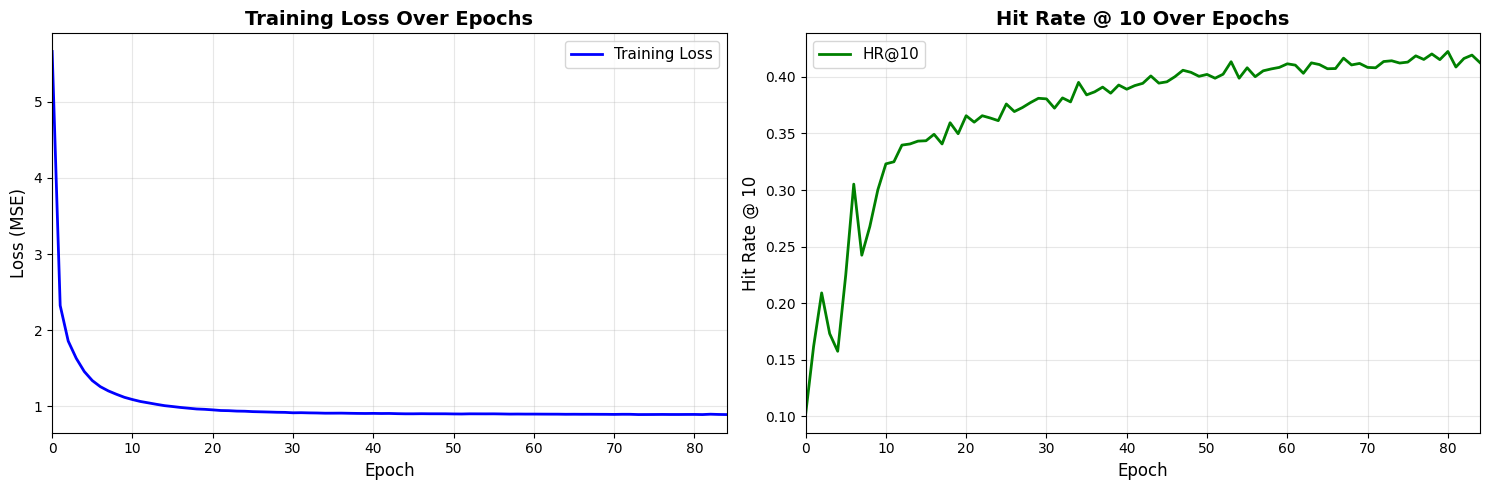

Training Summary
Final Training Loss: 0.892338
Best Test RMSE: 0.870410 (at epoch 74)
Best Validation RMSE: 0.866036 (at epoch 74)
Best HR@10: 0.412228 (at epoch 74)
Best NDCG@10: 0.087042 (at epoch 74)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Training Loss
epochs = range(len(train_losses))
ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xlim([0, len(epochs)-1])

# Plot 2: Hit Rate @ 10
ax2.plot(epochs, train_hr_at_10, 'g-', linewidth=2, label='HR@10')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Hit Rate @ 10', fontsize=12)
ax2.set_title('Hit Rate @ 10 Over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_xlim([0, len(epochs)-1])

plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 70)
print("Training Summary")
print("=" * 70)
print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Best Test RMSE: {best_test_rmse:.6f} (at epoch {best_epoch})")
print(f"Best Validation RMSE: {best_val_rmse:.6f} (at epoch {best_epoch})")
print(f"Best HR@10: {best_hr_at_10:.6f} (at epoch {best_epoch})")
print(f"Best NDCG@10: {best_ndcg_at_10:.6f} (at epoch {best_epoch})")
print("=" * 70)


In [16]:
# Print final best metrics (using checkpoint data if available)
print("=" * 70)
print("FINAL BEST METRICS")
print("=" * 70)
if os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=device , weights_only=False)
    print(f"Best Epoch: {checkpoint['epoch']}")
    print(f"Best Validation RMSE: {checkpoint['val_rmse']:.6f}")
    print(f"Best Test RMSE: {checkpoint['test_rmse']:.6f}")
    print(f"Best HR@10: {checkpoint['hr_at_10']:.6f}")
    print(f"Best NDCG@10: {checkpoint['ndcg_at_10']:.6f}")
else:
    print(f"Best Epoch: {best_epoch}")
    print(f"Best Test RMSE: {best_test_rmse:.6f}")
    print(f"Best Validation RMSE: {best_val_rmse:.6f}")
    print(f"Best HR@10: {best_hr_at_10:.6f}")
    print(f"Best NDCG@10: {best_ndcg_at_10:.6f}")
print("=" * 70)


FINAL BEST METRICS
Best Epoch: 74
Best Validation RMSE: 0.866036
Best Test RMSE: 0.870410
Best HR@10: 0.412228
Best NDCG@10: 0.087042
